# Pipeline
in this file we build a pipeline to 
- load (local) fmnist csv dataset
- preprocess 
    - normalize 
    - convert to np 
- and train an AE (simple conv, some casual architechture). 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.preprocessing import Normalizer, MinMaxScaler, minmax_scale
from sklearn.pipeline import Pipeline


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## import data

import csv as data frame (pandas) and convert to nparray

In [2]:
df_train = pd.read_csv('archive/fashion-mnist_train.csv') # df for dataframe
df_test = pd.read_csv('archive/fashion-mnist_test.csv')


separate labels
X_train.pop pops specific features (original feature is deleted in X_train)

In [3]:
labels_train = df_train.pop('label')
labels_test = df_test.pop('label')
#labels_train

create sklearn pipeline for normalizing

In [4]:
#normalize = Pipeline(steps = ['minmax_normalize', MinMaxScaler()]) # choose transform

In [5]:
X_train_flat = df_train.to_numpy().astype('float32') / 255
X_test_flat = df_test.to_numpy().astype('float32') / 255

In [6]:
#normalize = MinMaxScaler() # choose transform
#normalize.fit(df_train); # fit transform
#X_train_flat = np.single(normalize.transform(df_train)) # is np.single() command necessary? 
#X_test_flat = np.single(normalize.transform(df_test))


reshape from vector to img

In [7]:
X_train = X_train_flat.reshape(-1,28,28)
X_test = X_test_flat.reshape(-1,28,28)

## build AE
design AE as specific architecture 
    right now: simple layer


In [46]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as kb
#import tensorflow.compat.v1.keras.backend as K

In [76]:
input_img = Input(shape=(28,28,1))
regularizer = regularizers.l1(10e-5)
latent_dim = 8
# model: encoder
encoded = Conv2D(32, (3, 3), 
                            activation='relu', 
                            padding='same')(input_img)
encoded = Conv2D(64, (3, 3), 
                            activation='relu', 
                            padding='same',
                            strides=(2, 2))(encoded)
encoded = Conv2D(64, (3, 3), 
                            activation='relu', 
                            padding='same')(encoded)
encoded = Conv2D(32, (3, 3), 
                            activation='relu', 
                            padding='same')(encoded)

#shape_before_flattening = K.int_shape(encoded)
shape_before_flattening = encoded.shape

encoded = Flatten()(encoded)
encoded = Dense(64, activation='relu')(encoded)

encoder = Model(input_img, encoded)

z_mu = layers.Dense(latent_dim)(encoded)
z_log_sigma = layers.Dense(latent_dim)(encoded)

encoder.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
flatten_4 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                401

sampling function

In [77]:
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = tf.random.normal(shape=[latent_dim],
                                mean=0., stddev=1.)
    return z_mu + tf.math.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mu, z_log_sigma])

In [78]:
# model: decoder
#input_encoded = layers.Input(K.int_shape(z)[1:])
input_encoded = layers.Input(z.shape[1:])

decoded = Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(input_encoded)
decoded = Reshape(shape_before_flattening[1:])(decoded)
decoded = Conv2DTranspose(32, (3, 3), 
                            activation='relu', 
                            padding='same',
                            strides=(2,2))(decoded)
decoded = Conv2D(1, (3, 3), 
                    activation='sigmoid', 
                    padding='same')(decoded)
decoder = Model(input_encoded, decoded)
z_decoded = decoder(z)


define loss

In [79]:
class CompositeReconstuctionError(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        x = y_true
        z_decoded = y_pred
        loss = self.vae_loss(x, z_decoded)
        #self.add_loss(loss, inputs=inputs)
        return loss
    
    def vae_loss(self, x, z_decoded):
        x = kb.flatten(x)
        z_decoded = kb.flatten(z_decoded)
        # reconstruction loss: binary cross entropy
        xbce_loss = tf.keras.metrics.binary_crossentropy(x, z_decoded)
        # kl div
        kl_loss = -5e-4 * kb.mean(1+z_log_sigma - kb.square(z_mu) - kb.exp(z_log_sigma), axis=-1)
        return kb.mean(xbce_loss + kl_loss)

def CompError(y_true, y_pred):
    x = y_true
    z_decoded = y_pred
    x = Flatten()(x)
    z_decoded = Flatten()(z_decoded)
    # reconstruction loss: binary cross entropy
    xbce_loss = tfkeras.metrics.binary_crossentropy(x, z_decoded)
    # kl div
    kl_loss = -5e-4 * tf.math.reduce_mean(1+z_log_sigma - tf.math.square(z_mu) - tf.math.exp(z_log_sigma), axis=-1)
    return tf.math.reduce_mean(xbce_loss + kl_loss)


define layer

In [80]:
class CustomVariationalLayer(tf.keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = kb.flatten(x)
        z_decoded = kb.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = tf.keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * kb.mean(1 + z_log_sigma - kb.square(z_mu) - kb.exp(z_log_sigma), axis=-1)
        return kb.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [82]:
# model: autoencoder (encoder + decoder)
vae = Model(input_img, y)

#optimizer = Adam(learning_rate=0.002)
#loss = tf.keras.losses.BinaryCrossentropy();
#loss = tf.keras.losses.MeanSquaredError()
#loss = CompositeReconstuctionError()
#loss = CompError

vae.compile(optimizer='rmsprop', loss=None)
vae.summary() # decoder part is folded here

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 28, 28, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_19[0][0]                  
___________________________________________________________________________________________

## train AE

In [23]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [24]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.0003)
#autoencoder.fit(X_train, X_train,
#                epochs=50,
#                batch_size=256,
#                validation_data=(X_test, X_test),
#                callbacks=[early_stopping], # stop the training when no improvements are made
#                verbose=1)

In [83]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.0003)
vae.fit(x=X_train, y=X_train,
        epochs=7,
        batch_size=16,
        callbacks=[early_stopping],
        validation_data=(X_test, X_test))

Epoch 1/7


TypeError: in user code:

    C:\Users\nanli\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\nanli\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\nanli\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\nanli\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2825 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\nanli\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3600 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\nanli\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\nanli\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:796 train_step
        loss = self.compiled_loss(
    C:\Users\nanli\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:242 __call__
        self._loss_metric.update_state(
    C:\Users\nanli\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\utils\metrics_utils.py:86 decorated
        update_op = update_state_fn(*args, **kwargs)
    C:\Users\nanli\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\metrics.py:177 update_state_fn
        return ag_update_state(*args, **kwargs)
    C:\Users\nanli\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\metrics.py:424 update_state  **
        with ops.control_dependencies([value_sum]):
    C:\Users\nanli\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\ops.py:5390 control_dependencies
        return get_default_graph().control_dependencies(control_inputs)
    C:\Users\nanli\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\func_graph.py:363 control_dependencies
        self.control_captures.add(graph_element)
    C:\Users\nanli\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\keras_tensor.py:241 __hash__
        raise TypeError('Tensors are unhashable. (%s)'

    TypeError: Tensors are unhashable. (KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_sum_6/Sum:0', description="created by layer 'tf.math.reduce_sum_6'"))Instead, use tensor.ref() as the key.


In [53]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = vae.predict(X_test)

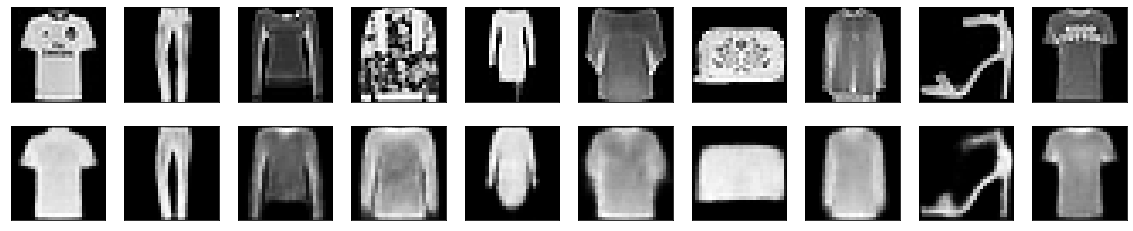

In [54]:
import matplotlib.pyplot as plt

n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #plt.imshow(X_test_normalized[i].reshape(28, 28))
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## combinging labels/categories


In [43]:
df_decoded_imgs = pd.DataFrame(data=decoded_imgs.reshape(-1,784))
#df_decoded_imgs = df_decoded_imgs.join(labels_test)
#df_decoded_imgs

filter by categories

In [83]:
#for i in range(10): # it should be better this way if each category has the same number of items

In [56]:
decoded_imgs_0 = decoded_imgs[labels_test==0]
decoded_imgs_1 = decoded_imgs[labels_test==1]
decoded_imgs_2 = decoded_imgs[labels_test==2]
decoded_imgs_3 = decoded_imgs[labels_test==3]
decoded_imgs_4 = decoded_imgs[labels_test==4]

decoded_imgs_5 = decoded_imgs[labels_test==5]
decoded_imgs_6 = decoded_imgs[labels_test==6]
decoded_imgs_7 = decoded_imgs[labels_test==7]
decoded_imgs_8 = decoded_imgs[labels_test==8]
decoded_imgs_9 = decoded_imgs[labels_test==9]



In [57]:
original_imgs_0 = X_test[labels_test==0]
original_imgs_1 = X_test[labels_test==1]
original_imgs_2 = X_test[labels_test==2]
original_imgs_3 = X_test[labels_test==3]
original_imgs_4 = X_test[labels_test==4]

original_imgs_5 = X_test[labels_test==5]
original_imgs_6 = X_test[labels_test==6]
original_imgs_7 = X_test[labels_test==7]
original_imgs_8 = X_test[labels_test==8]
original_imgs_9 = X_test[labels_test==9]


## show by labels/categories

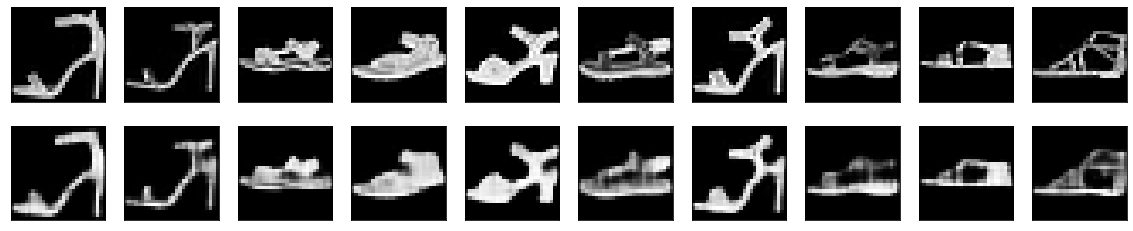

In [63]:

n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #plt.imshow(X_test_normalized[i].reshape(28, 28))
    plt.imshow(original_imgs_0[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_0[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## calculate loss for each category

In [84]:
loss_test = np.ndarray(10)

In [85]:

loss_test[0] = loss(original_imgs_0.reshape(-1,784),decoded_imgs_0.reshape(-1,784)).numpy()
loss_test[1] = loss(original_imgs_1.reshape(-1,784),decoded_imgs_1.reshape(-1,784)).numpy()
loss_test[2] = loss(original_imgs_2.reshape(-1,784),decoded_imgs_2.reshape(-1,784)).numpy()
loss_test[3] = loss(original_imgs_3.reshape(-1,784),decoded_imgs_3.reshape(-1,784)).numpy()
loss_test[4] = loss(original_imgs_4.reshape(-1,784),decoded_imgs_4.reshape(-1,784)).numpy()

loss_test[5] = loss(original_imgs_5.reshape(-1,784),decoded_imgs_5.reshape(-1,784)).numpy()
loss_test[6] = loss(original_imgs_6.reshape(-1,784),decoded_imgs_6.reshape(-1,784)).numpy()
loss_test[7] = loss(original_imgs_7.reshape(-1,784),decoded_imgs_7.reshape(-1,784)).numpy()
loss_test[8] = loss(original_imgs_8.reshape(-1,784),decoded_imgs_8.reshape(-1,784)).numpy()
loss_test[9] = loss(original_imgs_9.reshape(-1,784),decoded_imgs_9.reshape(-1,784)).numpy()

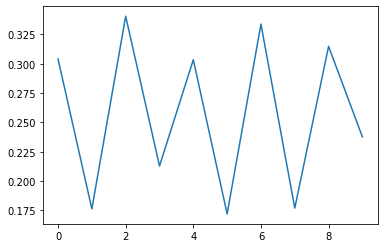

In [86]:
plt.plot(range(10),loss_test)